# pvlib-Python Forecasting (Albuquerque, NM)
### Install Standard Release 

In [1]:
# pip Upgrade
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1.1)


In [2]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# 4/20/2020: version 1.1.2 released. Code optimization, fix logic so only_use_cftime_datimes=False works as expected (issues #158 and #165). 
!pip install cftime==1.1.2


# Try to save Excel
!pip install openpyxl

In [3]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
%matplotlib inline

# Specify Location (Albuiquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=1)
irrad_vars = ['ghi','dni','dhi']

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pvlib/forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


### Create Model

In [4]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average  \
2020-06-23 06:00:00-06:00                                                0.0                
2020-06-23 09:00:00-06:00                                                0.0                
2020-06-23 12:00:00-06:00                                                4.0                
2020-06-23 15:00:00-06:00                                                7.0                
2020-06-23 18:00:00-06:00                                                3.0                

                           Total_cloud_cover_high_cloud_Mixed_intervals_Average  \
2020-06-23 06:00:00-06:00                                                0.0      
2020-06-23 09:00:00-06:00                                               32.0      
2020-06-23 12:00:00-06:00                                               16.0      
2020-06-23 15:00:00-06:00                                                0.0      
2020-06-23 18:00:00-06:00 

### Process Data with pvlib

In [5]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-06-23 06:00:00-06:00  24.287354    6.752893    0.136072    0.000000   
2020-06-23 09:00:00-06:00  17.542542    7.511967  377.576065  222.408581   
2020-06-23 12:00:00-06:00  16.842529    5.927459  787.754046  409.195512   
2020-06-23 15:00:00-06:00  30.250000    3.406896  833.421592  593.394441   
2020-06-23 18:00:00-06:00  44.050018    2.575250  370.022256  575.993357   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-06-23 06:00:00-06:00    0.136072          75.0         0.0        75.0   
2020-06-23 09:00:00-06:00  248.902685          42.0         0.0        37.0   
2020-06-23 12:00:00-06:00  400.661163          24.0         4.0        19.0   
2020-06-23 15:00:00-06:00  303.602986           7.0         7.0         0.0   
2020-06-23 18:00:00-06:00  110.676705           3.0         3.0         0.0   

                           high_clouds  
2020-06-23 06:00:00-06:00  

### GFS'S Class

In [6]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-06-23 06:00:00-06:00  24.287354    6.752893    0.136072    0.000000   
2020-06-23 09:00:00-06:00  17.542542    7.511967  377.576065  222.408581   
2020-06-23 12:00:00-06:00  16.842529    5.927459  787.754046  409.195512   
2020-06-23 15:00:00-06:00  30.250000    3.406896  833.421592  593.394441   
2020-06-23 18:00:00-06:00  44.050018    2.575250  370.022256  575.993357   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-06-23 06:00:00-06:00    0.136072          75.0         0.0        75.0   
2020-06-23 09:00:00-06:00  248.902685          42.0         0.0        37.0   
2020-06-23 12:00:00-06:00  400.661163          24.0         4.0        19.0   
2020-06-23 15:00:00-06:00  303.602986           7.0         7.0         0.0   
2020-06-23 18:00:00-06:00  110.676705           3.0         3.0         0.0   

                           high_clouds  
2020-06-23 06:00:00-06:00  

## Cloud Cover & Radiation

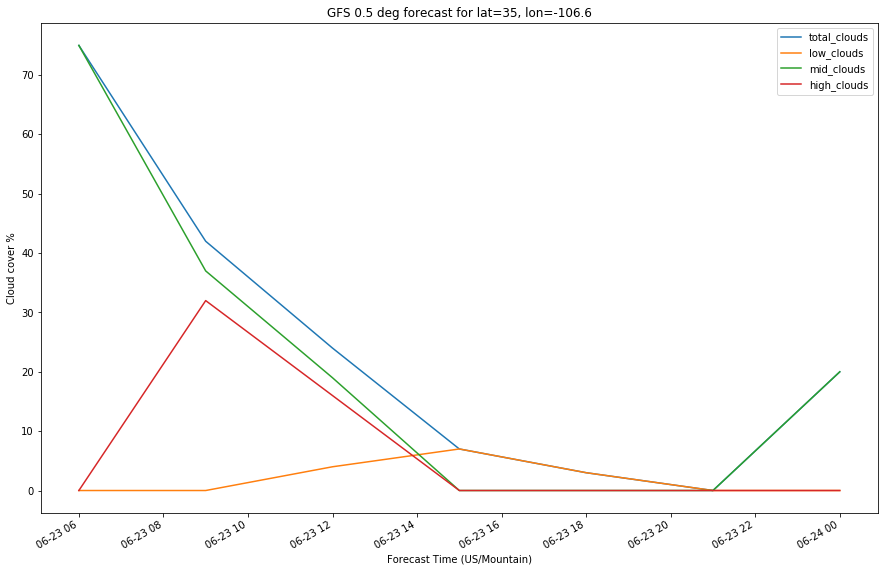

In [7]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

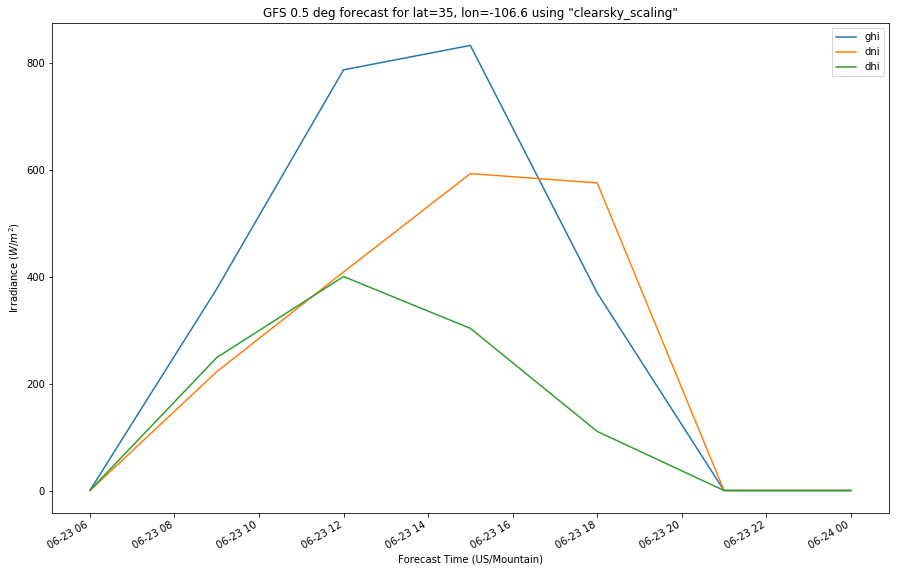

In [8]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

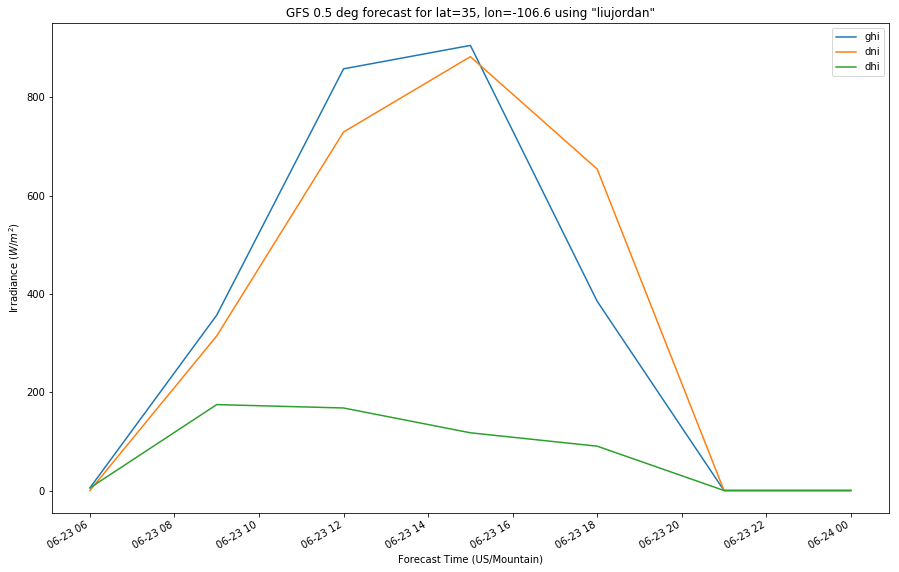

In [9]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

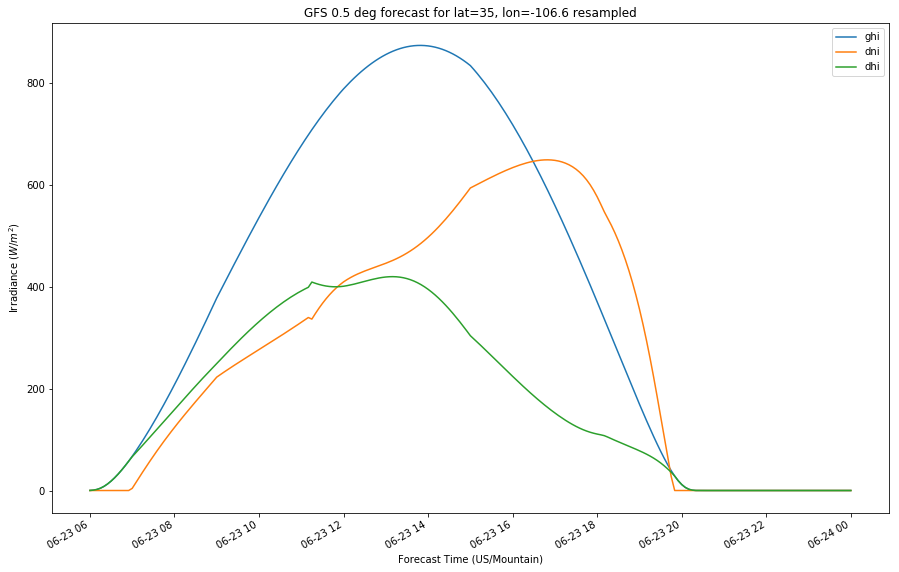

In [10]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

## Weather Models
### GFS
The Global Forecast System is the US model that provides forecast for the entire globe (6hr update)
### HRRR

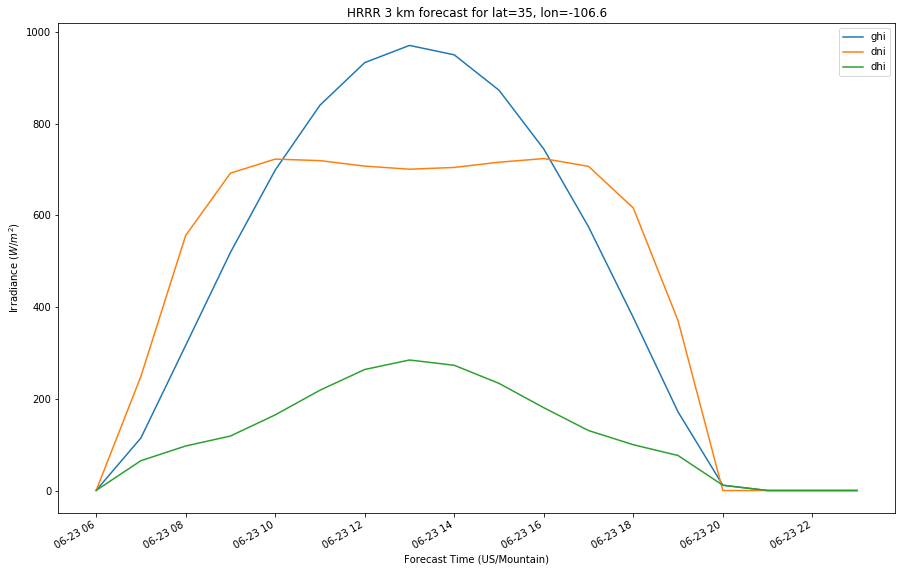

In [11]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

In [12]:
hrrr_data=data[irrad_vars]
hrrr_data.describe()

,ghi,dni,dhi
count,18.000000,18.000000,18.000000
mean,449.922051,454.862458,123.318209
std,381.274953,317.124463,101.395196
min,0.000000,0.000000,0.000000
25%,37.310506,62.291258,24.903991
50%,448.371523,654.289491,109.367038
75%,816.592598,707.459183,209.229426
max,970.862785,724.000541,284.690063


### RAP

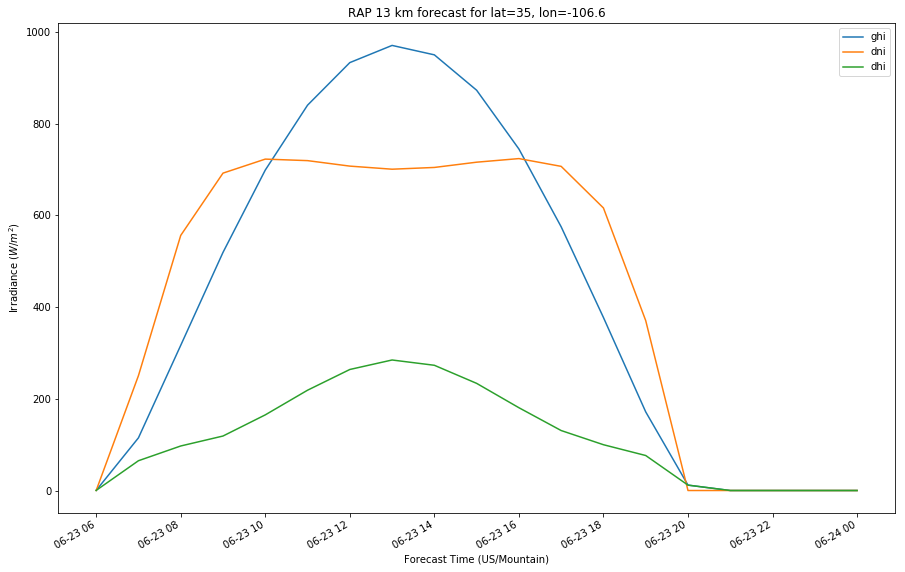

In [13]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

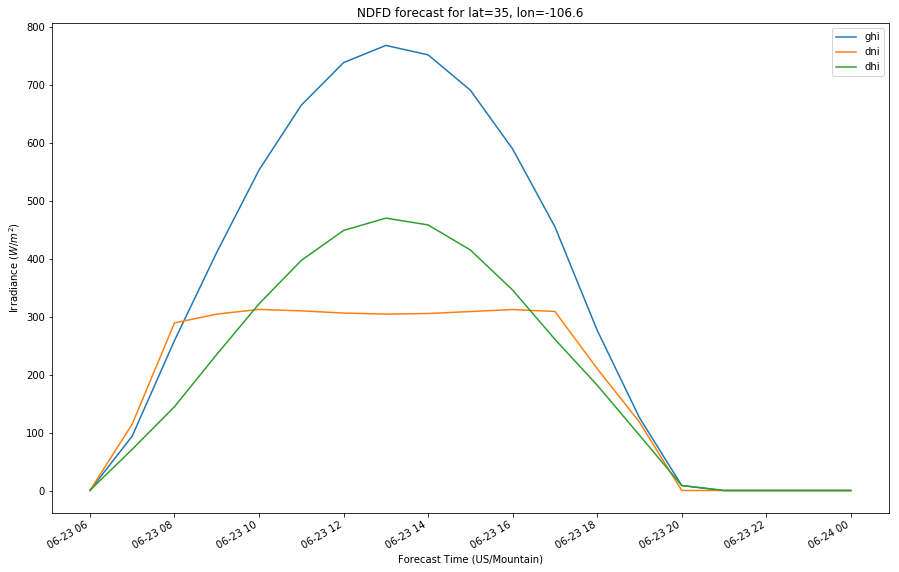

In [14]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

In [15]:
ndfd_data=data[irrad_vars]
ndfd_data.describe()

,ghi,dni,dhi
count,19.000000,19.000000,19.000000
mean,336.466474,184.682279,203.094472
std,304.976435,142.126319,182.022774
min,0.000000,0.000000,0.000000
25%,4.420432,0.000000,4.420432
50%,276.809108,289.472661,181.997584
75%,627.829069,307.864949,371.906883
max,768.923321,312.884150,470.570586


# PV Power Forecast - HRRR

In [16]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain
from pvlib import pvsystem

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['iPower__SHO_5_2__240V_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = pvsystem.PVSystem(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=14, strings_per_inverter=1)

# fx is a common abbreviation for forecast
fx_model = HRRR()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [17]:
invdb = pvsystem.retrieve_sam('CECInverter')
invdb

,ABB__MICRO_0_25_I_OUTD_US_208__208V_,ABB__MICRO_0_25_I_OUTD_US_240__240V_,ABB__MICRO_0_3_I_OUTD_US_208__208V_,ABB__MICRO_0_3_I_OUTD_US_240__240V_,ABB__MICRO_0_3HV_I_OUTD_US_208__208V_,ABB__MICRO_0_3HV_I_OUTD_US_240__240V_,ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_,ABB__PVI_10_0_I_OUTD_x_US_480_y_z__480V_,ABB__PVI_12_0_I_OUTD_x_US_480_y__480V_,ABB__PVI_3_0_OUTD_S_US__208V_,...,Zigor__Sunzet_3_TL_US__240V_,i_Energy__GT260__240V_,iPower__SHO_1_1__120V_,iPower__SHO_2_0__240V_,iPower__SHO_2_5__240V_,iPower__SHO_3_0__240V_,iPower__SHO_3_5__240V_,iPower__SHO_4_6__208V_,iPower__SHO_4_8__240V_,iPower__SHO_5_2__240V_
Vac,208,240,208,240,208,240,208,480,480,208,...,240,240,120,240,240,240,240,208,240,240
Pso,2.08961,2.24041,1.84651,1.95054,1.76944,1.84378,46.8638,67.7909,62.5547,18.1663,...,36.0334,2.5301,22.0954,24.4658,42.7765,31.682,64.7742,54.5701,85.1457,62.4867
Paco,250,250,300,300,300,300,10000,10000,12000,3000,...,3180,230,1100,2000,2500,3000,3500,4600,4800,5200
Pdco,259.589,259.492,311.669,311.581,312.421,312.005,10488.3,10296,12358.8,3142.3,...,3315.65,245.63,1194.09,2161.88,2632.84,3205.93,3641.84,4797.81,4968.03,5382.86
Vdco,40,40,40,40,45,45,320,362,370,310,...,375,40,182,199,218,222.5,263,254,263,280
C0,-4.1e-05,-3.9e-05,-3.3e-05,-3.4e-05,-4.5e-05,-3.5e-05,-2.7759e-06,-1.38839e-06,-1.009e-06,-8.03949e-06,...,-7.98467e-06,6.2e-05,-2.1e-05,-1.3e-05,-1.4e-05,-8.21046e-06,-9.08073e-06,-5.99928e-06,-6.16035e-06,-4.63524e-06
C1,-9.1e-05,-0.000132,-0.000192,-0.000256,-0.000196,-0.000227,-3.6e-05,-4.9e-05,-5.6e-05,-1.1e-05,...,-7.5e-05,-9.8e-05,5.7e-05,5.5e-05,6.1e-05,3.6e-05,3.5e-05,2.8e-05,3.4e-05,4.4e-05
C2,0.000494,0.002418,0.000907,0.002453,0.001959,-0.000526,0.000305,-0.00052,-0.001437,0.000999,...,0.000544,0.000231,0.002001,0.001703,0.002053,0.001708,0.001417,0.001381,0.000586,0.00126
C3,-0.013171,-0.014926,-0.031742,-0.028223,-0.023725,-0.041214,-0.002351,-0.003855,-0.007112,-0.000287,...,-0.000338,0.121032,0.000623,0.000315,0.00153,0.00086,0.001218,0.000889,0.000195,0.000367
Pnt,0.075,0.075,0.09,0.09,0.09,0.09,0.1,0.4,0.4,0.1,...,0.954,0.069,0.33,0.6,0.75,0.9,1.05,1.38,1.44,1.56


## ModelChain Attributes

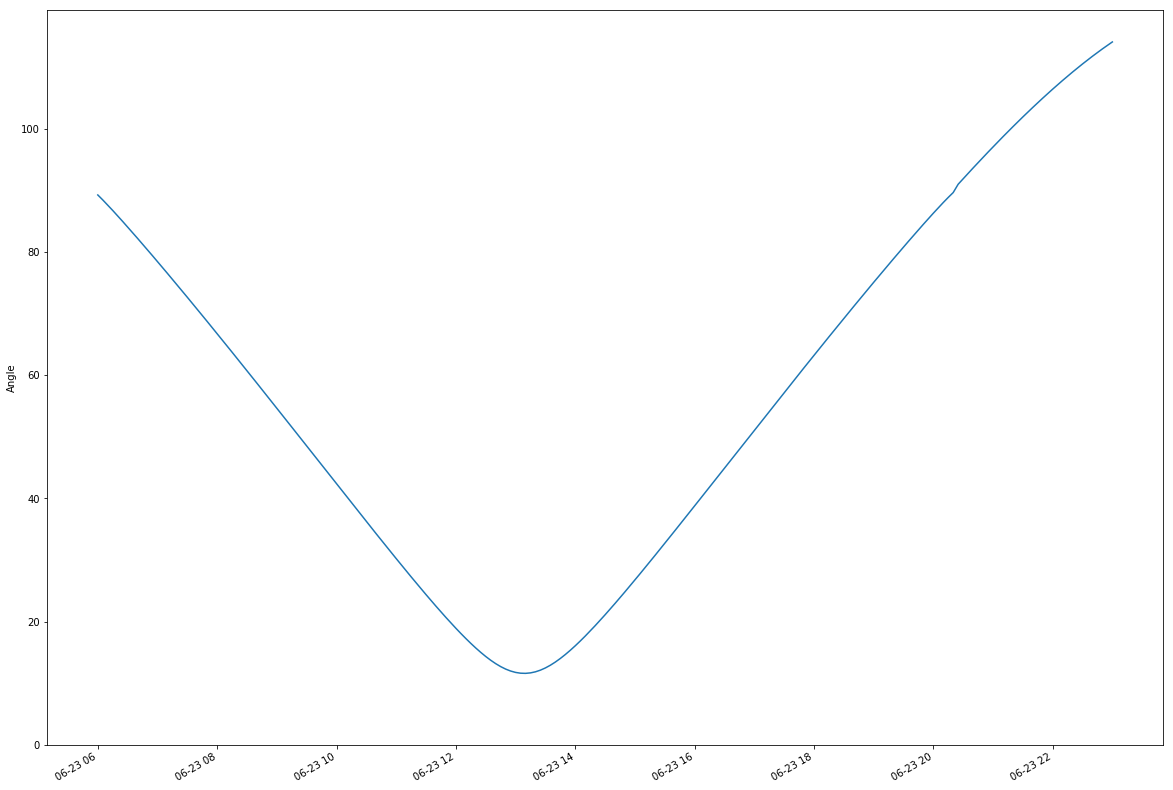

In [18]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

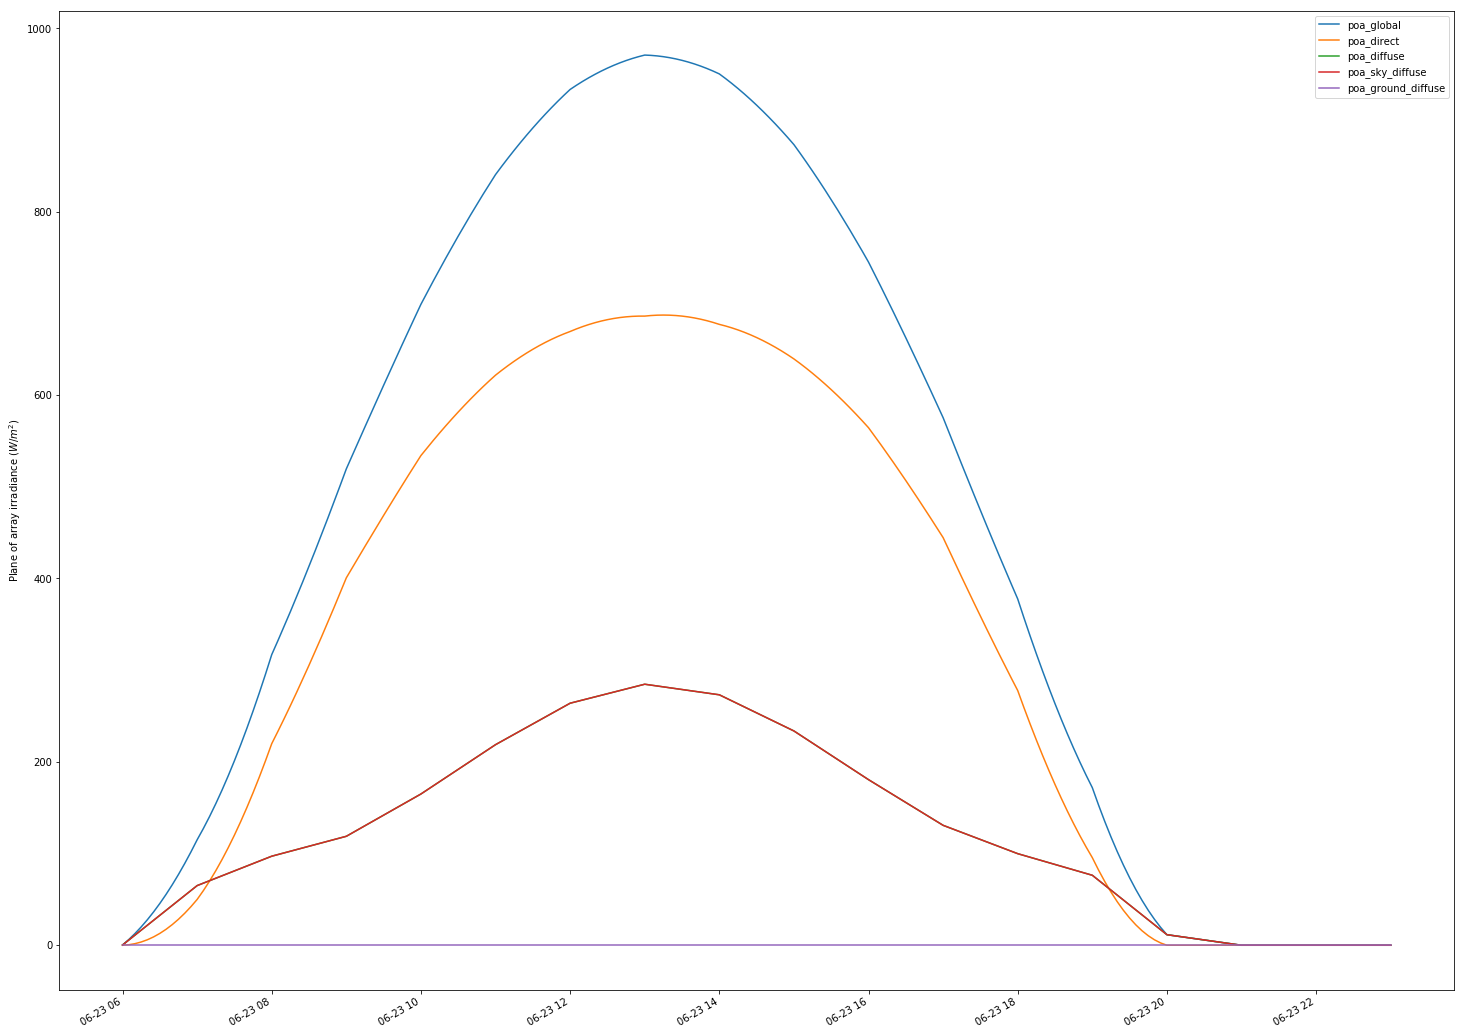

In [19]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

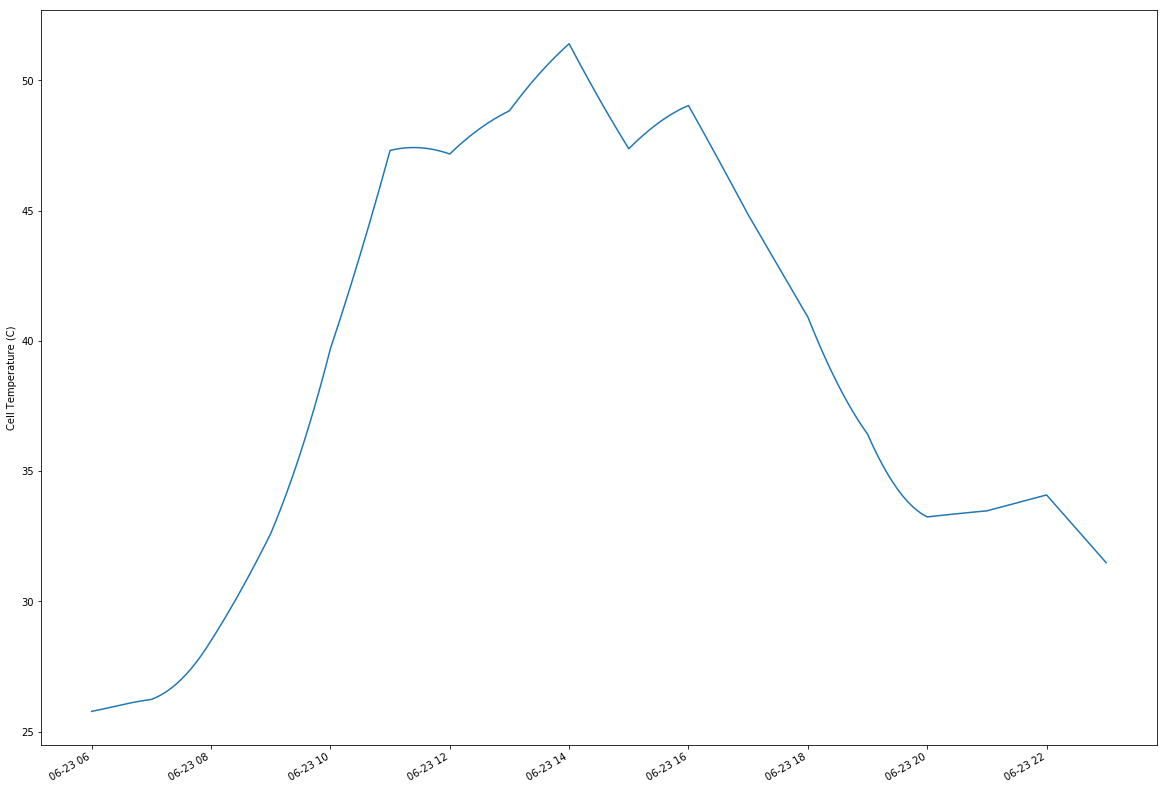

In [20]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

## MC DC Power

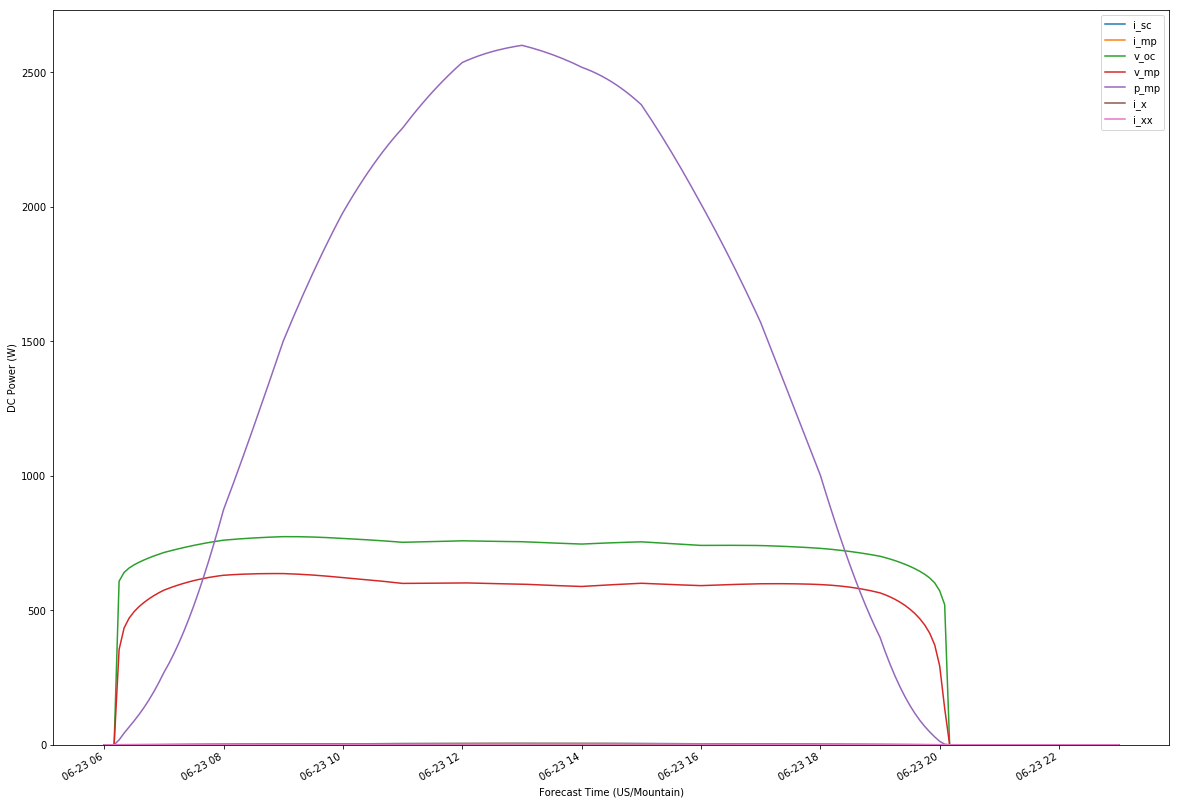

In [21]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [22]:
mc.dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,2.385271,2.127844,600.034385,476.860452,1279.637906,2.329230,1.552083
std,1.867899,1.661213,289.095738,234.562159,997.616358,1.825121,1.185144
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.322077,0.290484,678.116267,518.274690,146.492628,0.313743,0.231038
50%,2.488435,2.228079,741.300098,594.897321,1381.086441,2.427698,1.682834
75%,4.291225,3.821731,755.184789,600.530728,2292.259472,4.191707,2.755795
max,4.897580,4.353766,773.610340,636.365326,2599.740876,4.785998,3.089219


In [23]:
mc.dc.fillna(0).to_csv('HRRR DC June 23.csv', encoding='utf-8')

## MC AC Power

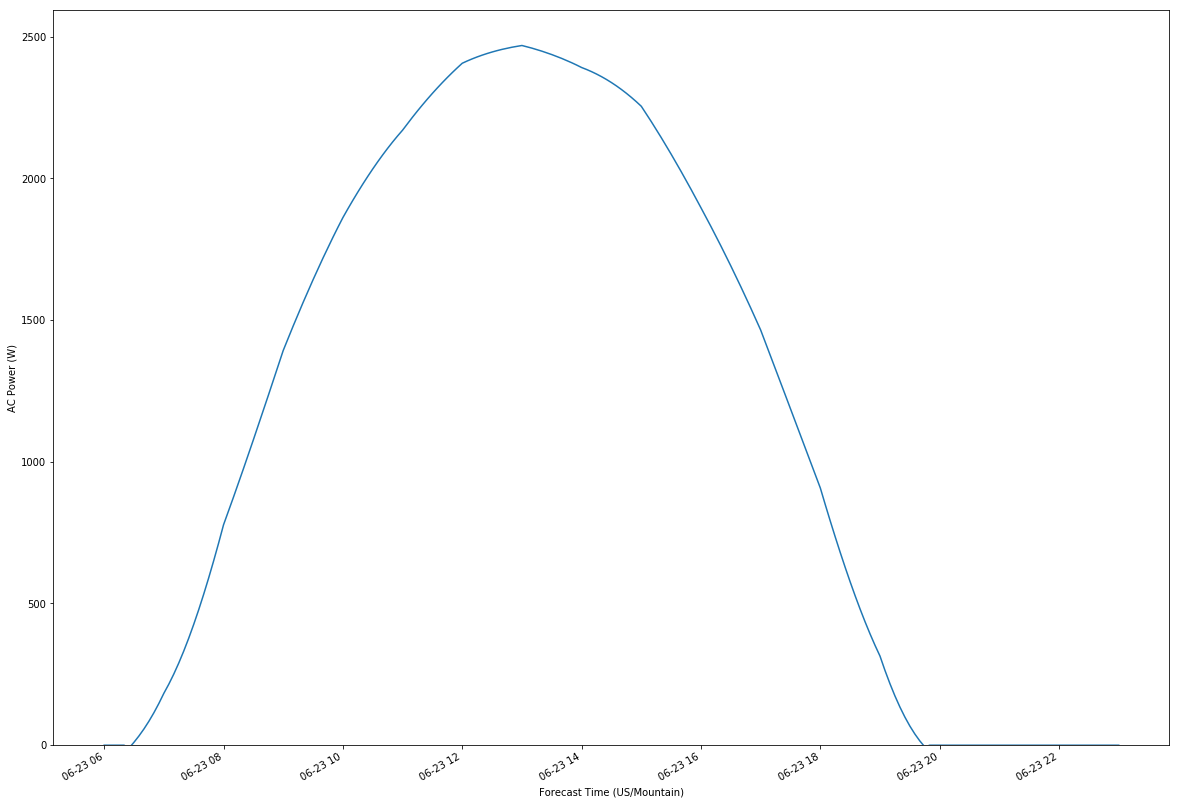

In [24]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [25]:
mc.ac.describe()

count     205.000000
mean     1192.627893
std       958.545453
min       -11.672889
25%        66.175799
50%      1279.687080
75%      2170.585019
max      2469.679741
dtype: float64

In [26]:
mc.ac.fillna(0)

2020-06-23 06:00:00-06:00      -1.560000
2020-06-23 06:05:00-06:00      -1.560000
2020-06-23 06:10:00-06:00      -1.560000
2020-06-23 06:15:00-06:00      -1.560000
2020-06-23 06:20:00-06:00      -1.560000
2020-06-23 06:25:00-06:00     -11.672889
2020-06-23 06:30:00-06:00       8.942880
2020-06-23 06:35:00-06:00      31.300529
2020-06-23 06:40:00-06:00      55.954787
2020-06-23 06:45:00-06:00      83.202131
2020-06-23 06:50:00-06:00     113.200614
2020-06-23 06:55:00-06:00     146.034787
2020-06-23 07:00:00-06:00     181.746726
2020-06-23 07:05:00-06:00     214.153383
2020-06-23 07:10:00-06:00     249.817703
2020-06-23 07:15:00-06:00     288.752893
2020-06-23 07:20:00-06:00     330.943299
2020-06-23 07:25:00-06:00     376.347969
2020-06-23 07:30:00-06:00     424.903942
2020-06-23 07:35:00-06:00     476.529466
2020-06-23 07:40:00-06:00     531.126991
2020-06-23 07:45:00-06:00     588.585971
2020-06-23 07:50:00-06:00     648.785561
2020-06-23 07:55:00-06:00     711.596987
2020-06-23 08:00

In [27]:
mc.ac.fillna(0).to_csv('HRRR AC June 23.csv', encoding='utf-8')

### HRRR Irradiance Data

In [28]:
hrrr_data

,ghi,dni,dhi
2020-06-23 06:00:00-06:00,0.253858,0.000000,0.253858
2020-06-23 07:00:00-06:00,114.687788,249.165031,65.061725
2020-06-23 08:00:00-06:00,316.640281,556.403677,97.121179
2020-06-23 09:00:00-06:00,519.361851,692.282631,118.845173
2020-06-23 10:00:00-06:00,698.934310,722.873704,164.968883
2020-06-23 11:00:00-06:00,840.471721,719.564664,218.769812
2020-06-23 12:00:00-06:00,933.357894,707.593650,263.984801
2020-06-23 13:00:00-06:00,970.862785,700.858207,284.690063
2020-06-23 14:00:00-06:00,950.305140,704.678293,273.160654
2020-06-23 15:00:00-06:00,873.149950,716.155971,233.722392


In [29]:
hrrr_data.to_csv('HRRR June 23.csv', encoding='utf-8')

# PV Power Forecast - NDFD

In [30]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain
from pvlib import pvsystem

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['iPower__SHO_5_2__240V_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = pvsystem.PVSystem(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=14, strings_per_inverter=1)

# fx is a common abbreviation for forecast
fx_model = NDFD()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

## ModelChain Attributes

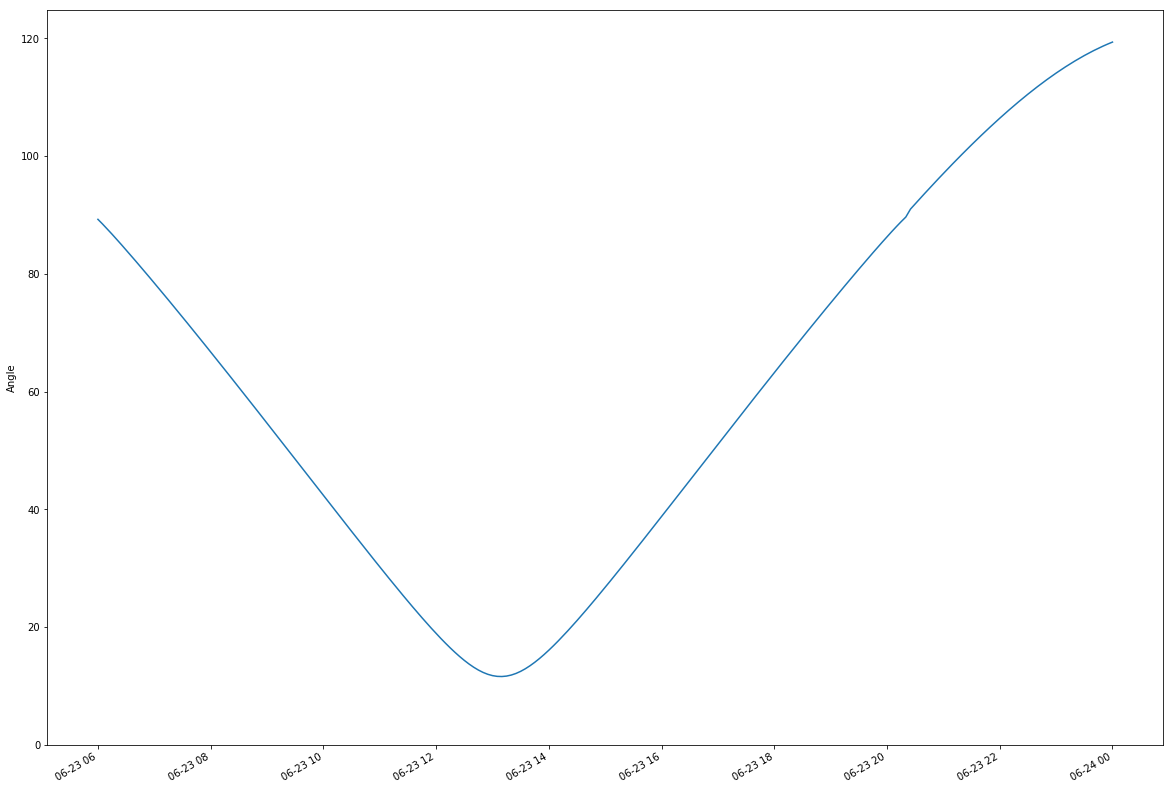

In [31]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

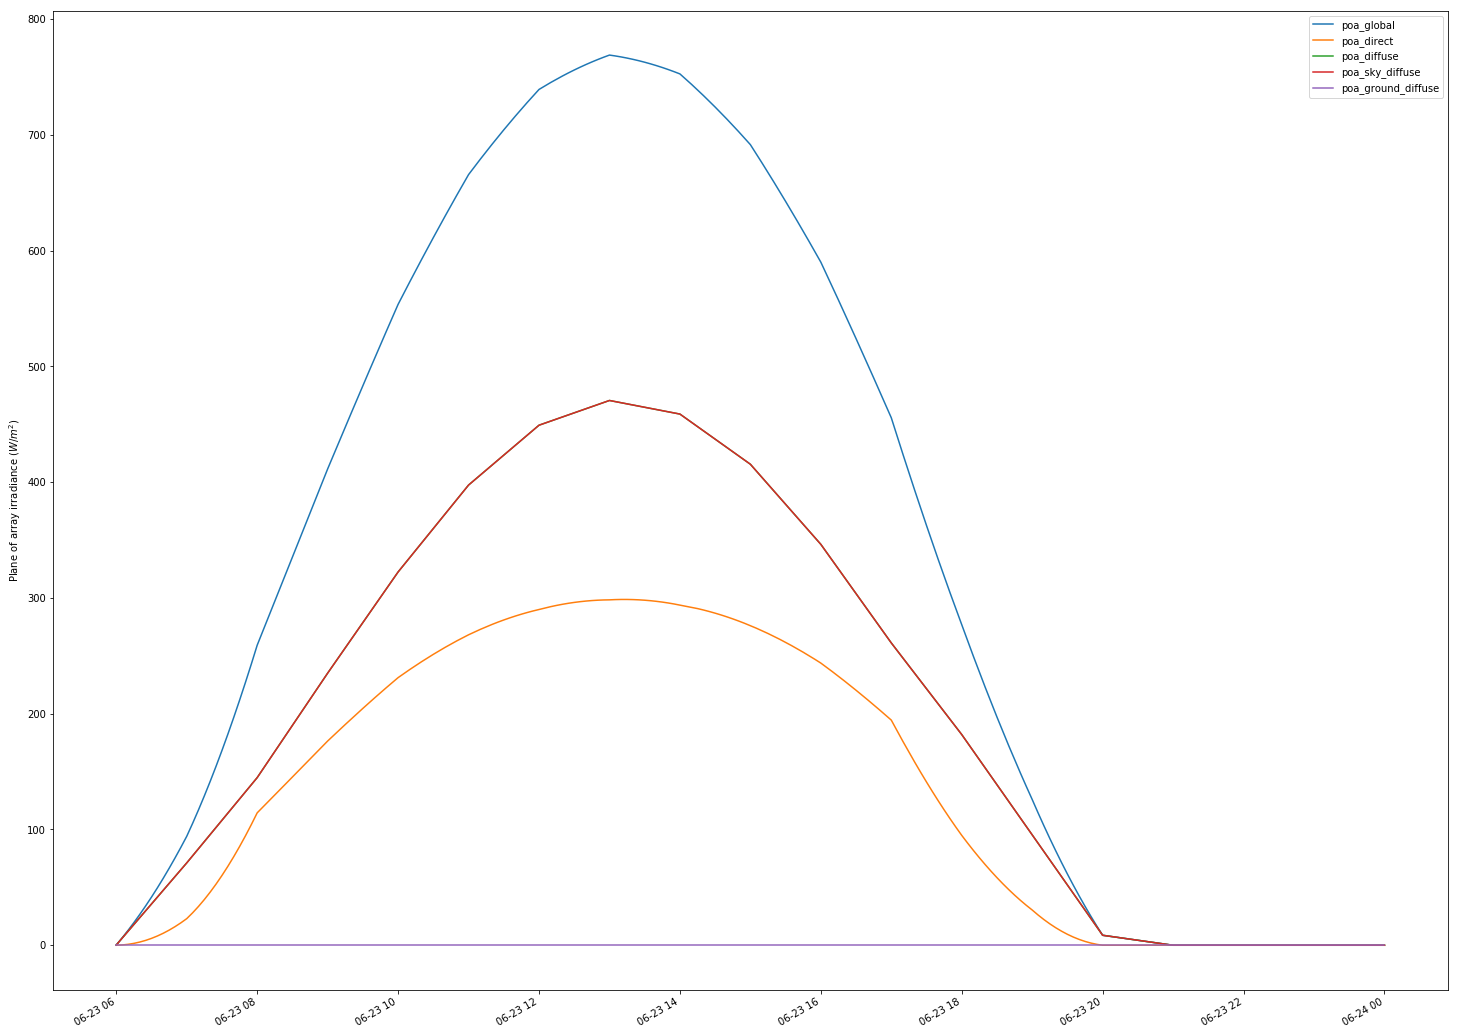

In [32]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

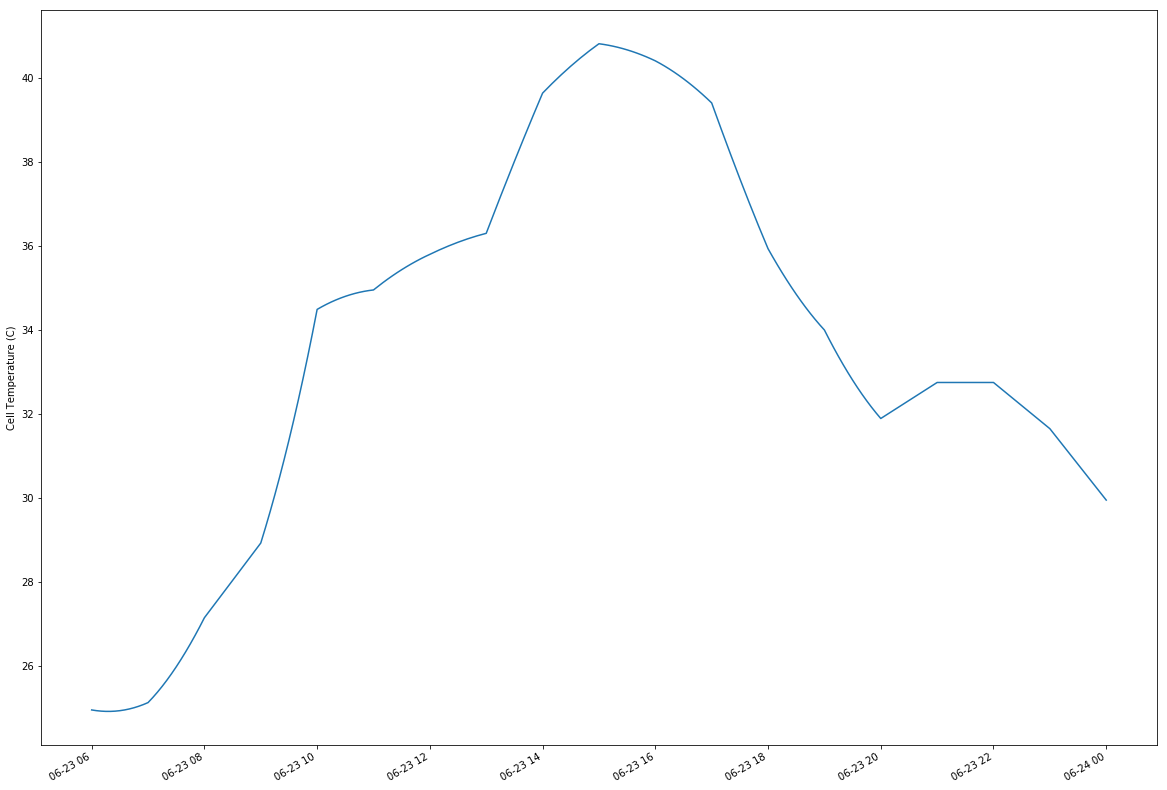

In [33]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

## MC DC Power

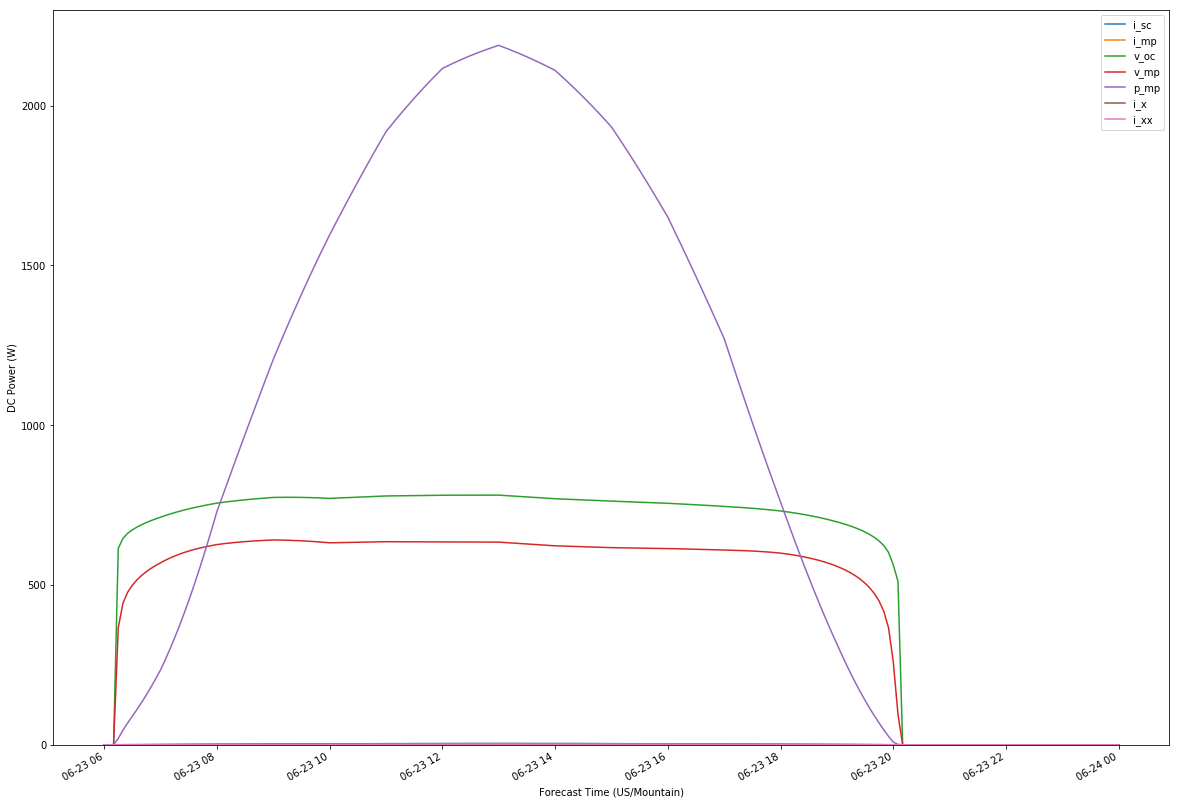

In [34]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [35]:
mc.dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,1.783713,1.597323,573.948271,461.354627,994.998926,1.740822,1.188200
std,1.485208,1.327395,317.125210,259.951028,837.731372,1.450149,0.971362
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.114454,0.103490,623.022098,416.948251,45.862937,0.111477,0.082554
50%,1.764498,1.587796,747.949337,611.060353,971.552966,1.720578,1.217144
75%,3.308166,2.957558,772.450883,632.923124,1844.196576,3.229266,2.185537
max,3.862599,3.451649,781.211680,640.962080,2188.846779,3.771945,2.510663


In [36]:
mc.dc.fillna(0).to_csv('NDFD DC June 23.csv', encoding='utf-8')

## MC AC Power

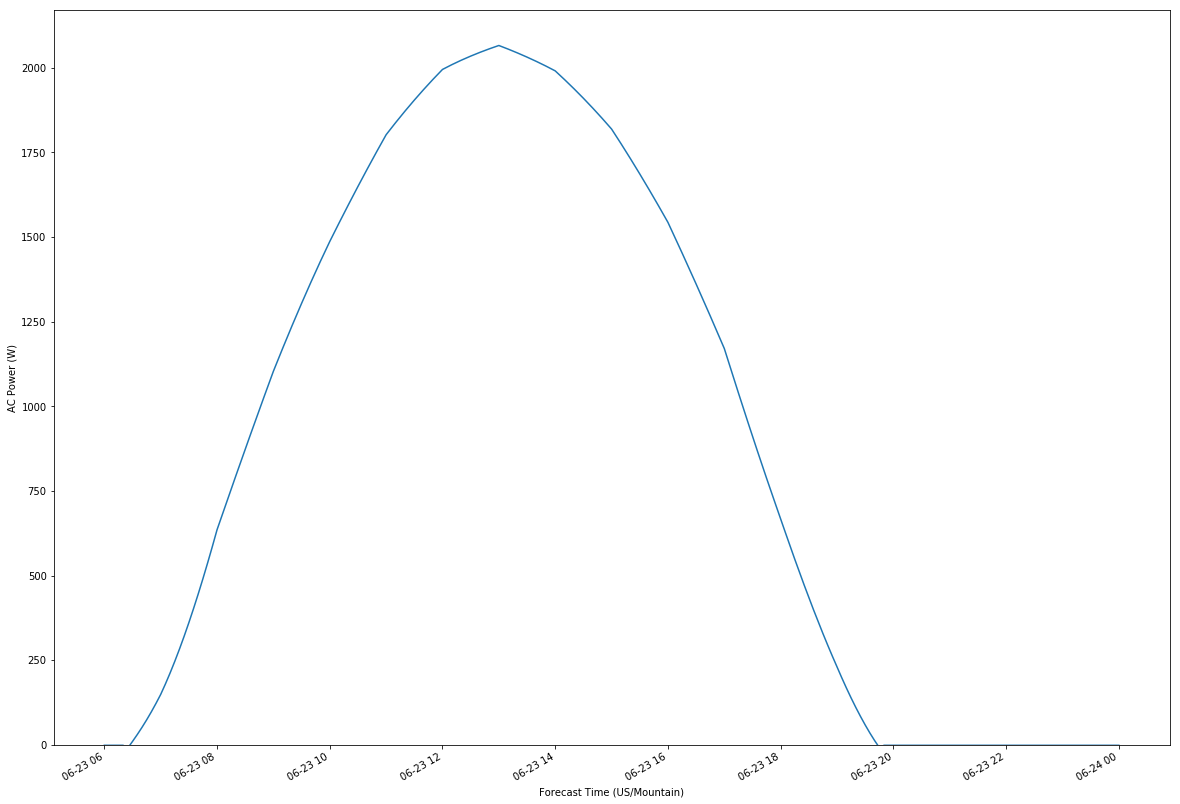

In [37]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [38]:
mc.ac.describe()

count     217.000000
mean      916.222071
std       798.964672
min        -9.713565
25%        -1.560000
50%       872.869553
75%      1731.654466
max      2065.666884
dtype: float64

In [39]:
mc.ac.fillna(0).to_csv('NDFD AC June 23.csv', encoding='utf-8')

### NDFD Irradiance Data

In [40]:
ndfd_data

,ghi,dni,dhi
2020-06-23 06:00:00-06:00,0.217185,0.000000,0.217185
2020-06-23 07:00:00-06:00,93.967308,114.668194,71.128907
2020-06-23 08:00:00-06:00,259.011737,289.472661,144.805485
2020-06-23 09:00:00-06:00,411.334584,304.738521,235.029626
2020-06-23 10:00:00-06:00,553.555970,312.884150,322.437702
2020-06-23 11:00:00-06:00,665.653599,310.357154,397.505864
2020-06-23 12:00:00-06:00,739.219448,306.565737,449.212810
2020-06-23 13:00:00-06:00,768.923321,304.738088,470.570586
2020-06-23 14:00:00-06:00,752.641667,305.757030,458.831443
2020-06-23 15:00:00-06:00,691.534756,309.164162,415.494211


In [41]:
hrrr_data.to_csv('NDFD June 23.csv', encoding='utf-8')